# Image Pyramid

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(fname):
    gray_img = cv2.imread(fname, 0)    # gray image
    bgr_img = cv2.imread(fname)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return gray_img, rgb_img

In [3]:
def gaussian_low_pass_filter(size_x, size_y, cutoff_ratio=0.5):
    H = np.zeros((size_x, size_y))
    cutoff = np.ceil(cutoff_ratio * 0.5 * size_x)
    if (size_x > size_y):
        cutoff = np.ceil(cutoff_ratio * 0.5 * size_y)
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = np.exp(-(u**2+v**2)/(2*(cutoff**2)))
#     print("low-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [4]:
def get_magnitude_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift)+1)
    return magnitude_spectrum, fshift

In [5]:
def img_back(fimage):
    fshift  = np.fft.ifftshift(fimage)
    img = np.fft.ifft2(fshift)
    img = img.real
    return img

In [6]:
def float_to_int(data):
    new_data = (data).astype(np.uint8)
    return new_data

In [7]:
def plot_img(img_1, img_2, camp=None):
    fig, ax = plt.subplots(1,2, figsize=[8, 6])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(img_1, cmap = camp)
    ax[1].imshow(img_2, cmap = camp)

In [8]:
def cv_save(fname, img):
    cv2.imwrite(fname, img)

# Subsample


In [9]:
def down_sample(img):
    sub_img = np.zeros((int(img.shape[0]/2), int(img.shape[1]/2)))
    for i in range(0, img.shape[0], 2):
        if i+1>=img.shape[0]:
            break
        i1 = i
        i2 = i+1
        for j in range(0, img.shape[1], 2):
            if j+1>=img.shape[1]:
                break
            j1 = j
            j2 = j+1
            sub_img[int(i/2), int(j/2)] = (img[i1, j1]+img[i1, j2]+img[i2, j1]+img[i2, j2])/4
    return sub_img

# Interpolation
We implement three interpolation mehtods
* Nearest-Neighbor
* Bilinear
* Bicubic

In [10]:
def interpolation(img, shape, method='BICUBIC'):
    if method == 'NEAREST':
        expand = nearest_neighbor_interpolation(img, shape)
        expand_spec, _ = get_magnitude_spectrum(expand)
        return expand, expand_spec
    elif method == 'BILINEAR':
        expand = bilinear_interpolation(img, shape)
        expand_spec, _ = get_magnitude_spectrum(expand)
        return expand, expand_spec
    elif method == 'BICUBIC':
        expand = bicubic_interpolation(img, shape)
        expand_spec, _ = get_magnitude_spectrum(expand)
        return expand, expand_spec

### Nearest-Neighbor Interpolation
* Get the sizes of new image(expand image) and old image.
* In order to map the nearest neighbor of new image to old image, we need to calculate their proportion.
* Assign position: 
\begin{equation*}
\frac{i \times \left( old\_height \right)}{new\_height}, \frac{j \times \left( old\_width \right)}{new\_width}
\end{equation*}
of old image to position i, j of new image

In [11]:
def nearest_neighbor_interpolation(img, shape):
    # get sizes
    h = img.shape[0]-1
    w = img.shape[1]-1
    expand = np.zeros((shape[0], shape[1]))
    for row in range(shape[0]):
        for col in range(shape[1]):
            # define new pixel with its nearest neighbor of origin image
            x = round(row*h/shape[0])
            y = round(col*w/shape[1])
            expand[row, col] = img[x, y]
    return expand

### Bilinear Interpolation
<img src="./src/bilinear.png" width="20%" height="20%">
The interpolation formula simplifies to
\begin{equation*}
f \left( x,y \right) \approx f(0,0) (1-x)(1-y) + f(1,0) x(1-y) + f(0,1) (1-x)y + f(1,1) xy
\end{equation*}

Equivalently, matrix operations:
\begin{equation*}
f(x,y) \approx \begin{bmatrix} 1-x & x \end{bmatrix} \begin{bmatrix} f(0,0) & f(0,1) \\ f(1,0) & f(1,1) \end{bmatrix} \begin{bmatrix}
1-y \\ y \end{bmatrix}
\end{equation*}

<a href="https://en.wikipedia.org/wiki/Bilinear_interpolation">Reference: Wikipedia</a>

In [12]:
def bilinear_interpolation(img, shape):
    h = img.shape[0]-1
    w = img.shape[1]-1
    expand = np.zeros((shape[0], shape[1]))
    for row in range(shape[0]):
        for col in range(shape[1]):
            x = row*h/shape[0]
            x_floor = int(np.floor(x))
            x_ceil = int(np.ceil(x))
            x_diff = x-x_floor
            y = col*w/shape[1]
            y_floor = int(np.floor(y))
            y_ceil = int(np.ceil(y))
            y_diff = y-y_floor
            
            expand[row, col] = img[x_floor, y_floor]*(1-x_diff)*(1-y_diff)+\
                               img[x_ceil, y_floor]*x_diff*(1-y_diff)+\
                               img[x_floor, y_ceil]*(1-x_diff)*y_diff+\
                               img[x_ceil, y_ceil]*x_diff*y_diff
    return expand

### Bicubic Interpolation
Model: \begin{equation*} f(x,y)=\sum_{i=0}^{3}\sum_{j=0}^{3} a_{ij}x^{j}y^{j}
\end{equation*}
Equivalently, matrix operations:
\begin{equation*}
f(x,y)= \begin{bmatrix} 1&x&x^2&x^3 \end{bmatrix} \begin{bmatrix} a_{00}&a_{01}&a_{02}&a_{03}\\
a_{10}&a_{11}&a_{12}&a_{13}\\
a_{20}&a_{21}&a_{22}&a_{23}\\
a_{30}&a_{31}&a_{32}&a_{33} \end{bmatrix} \begin{bmatrix}
1\\
y\\
y^2\\
y^3\end{bmatrix}
\end{equation*}

Given 4x4 known data points, we have \begin{equation}F=BAB^{T}\end{equation}

\begin{equation*}
\begin{bmatrix}
f(-1,-1)&f(-1,0)&f(-1,1)&f(-1,2)\\
f(0,-1)&f(0,0)&f(0,1)&f(0,2)\\
f(1,-1)&f(1,0)&f(1,1)&f(1,2)\\
f(2,-1)&f(2,0)&f(2,1)&f(2,2)
\end{bmatrix}=\begin{bmatrix}
(-1)^{3}&(-1)^{2}&-1&1\\
0^{3}&0^{2}&0&1\\
1^{3}&1^{2}&1&1\\
2^{3}&2^{2}&2&1
\end{bmatrix}\begin{bmatrix}
a_{3,3}&a_{3,2}&a_{3,1}&a_{3,0}\\
a_{2,3}&a_{2,2}&a_{2,1}&a_{2,0}\\
a_{1,3}&a_{1,2}&a_{1,1}&a_{1,0}\\
a_{0,3}&a_{0,2}&a_{0,1}&a_{0,0}\end{bmatrix}\begin{bmatrix}
(-1)^{3}&1^{3}&1^{3}&2^{3}\\
(-1)^{2}&0^{2}&1^{2}&2^{2}\\
-1&0&1&2\\
1&1&1&1
\end{bmatrix}
\end{equation*}

\begin{equation*}
F=BAB^{T} \Rightarrow A=B^{-1}F(B^{T})^{-1}=B^{-1}F(B^{-1})^{T}
\end{equation*}

\begin{equation*}
B=\begin{bmatrix}
-1&1&-1&1\\
0&0&0&1\\
1&1&1&1\\
8&4&2&1
\end{bmatrix};B^{-1}=\begin{bmatrix}
\frac{-1}{6}&\frac{1}{2}&\frac{-1}{2}&\frac{1}{6}\\
\frac{1}{2}&-1&\frac{1}{2}&0\\
\frac{-1}{3}&\frac{-1}{2}&1&\frac{-1}{6}\\
0&1&0&0
\end{bmatrix}
\end{equation*}

In [13]:
def bicubic_interpolation(img, shape):
    B_inv = np.array([[-1/6, 1/2, -1/2, 1/6],
                      [1/2, -1, 1/2, 0],
                      [-1/3, -1/2 ,1, -1/6],
                      [0, 1, 0, 0]])
    B_inv_T = B_inv.transpose()
    h = img.shape[0]-1
    w = img.shape[1]-1
    expand = np.zeros((shape[0], shape[1]))
    for row in range(shape[0]):
        for col in range(shape[1]):
            x = row*h/shape[0]
            x_2 = int(np.floor(x))
            x_3 = int(np.ceil(x))
            x_1 = x_2-1
            x_4 = x_3+1
            if x_1 < 0:
                x_1 = 0
            if x_4 > h:
                x_4 = h
                
            y = col*w/shape[1]
            y_2 = int(np.floor(y))
            y_3 = int(np.ceil(y))
            y_1 = y_2-1
            y_4 = y_3+1
            if y_1 < 0:
                y_1 = 0
            if y_4 > w:
                y_4 = w
                
            F = np.array([[img[x_1,y_1], img[x_1,y_2], img[x_1,y_3], img[x_1,y_4]],
                          [img[x_2,y_1], img[x_2,y_2], img[x_2,y_3], img[x_2,y_4]],
                          [img[x_3,y_1], img[x_3,y_2], img[x_3,y_3], img[x_3,y_4]],
                          [img[x_4,y_1], img[x_4,y_2], img[x_4,y_3], img[x_4,y_4]]])
            X = np.array([[np.power(x%1,3), np.power(x%1,2), np.power(x%1,1), np.power(x%1,0)]])
            Y = np.array([[np.power(y%1,3)],
                          [np.power(y%1,2)],
                          [np.power(y%1,1)],
                          [np.power(y%1,0)]])
            expand[row, col] = np.matmul(np.matmul(np.matmul(X, B_inv), F), np.matmul(B_inv_T, Y))
    return expand

In [14]:
def gaussian_pyramid(img):
    img_spec, fshift = get_magnitude_spectrum(img)
    gaussian_filter = gaussian_low_pass_filter(img.shape[0], img.shape[1])
    gaussian_spec = img_spec * gaussian_filter
    gaussian_f = fshift * gaussian_filter
    gaussian_img = img_back(gaussian_f)
    pyramid_img = down_sample(gaussian_img)
    pyramid_spec, _ = get_magnitude_spectrum(pyramid_img)
    return img, img_spec, pyramid_img, pyramid_spec

In [15]:
def laplacian_pyramid(origin, expand):
    p_img = origin - expand
    img_spec, _ = get_magnitude_spectrum(p_img)
    plot_img(p_img, img_spec, 'gray')

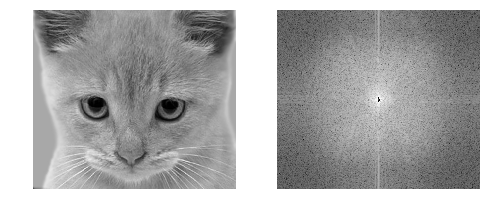

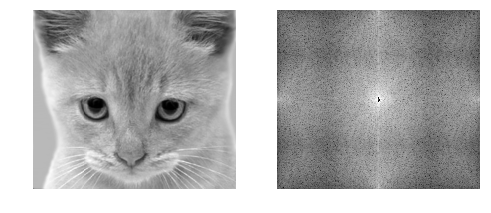

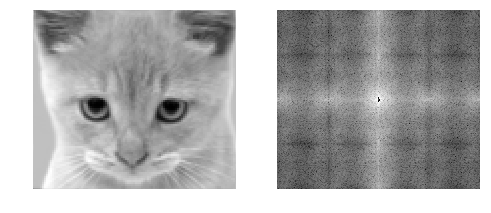

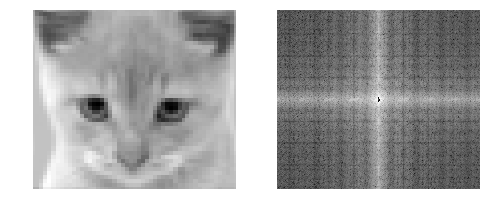

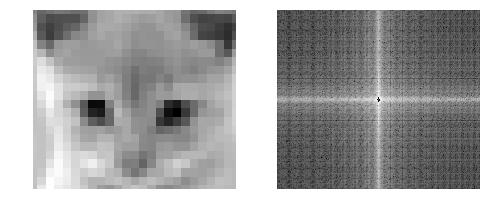

In [16]:
fname = 'cat'
ftype = 'bmp'
interpolation_type = 'NEAREST'
img, _ = read_image('./hw2_data/task1and2_hybrid_pyramid/'+fname+'.'+ftype)
shape = img.shape

origin, origin_spec, img, img_spec = gaussian_pyramid(img)
plot_img(origin, float_to_int(origin_spec), 'gray')
cv_save('./task2/'+fname+'.jpg', origin)
cv_save('./task2/'+fname+'_pyramid_1.jpg', img)

expand, expand_spec = interpolation(img, shape, method=interpolation_type)
cv_save('./task2/'+fname+'_expand_'+interpolation_type+'_1.jpg', expand)
plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')

for i in range(2, 5):
    origin, origin_spec, img, img_spec = gaussian_pyramid(img)
#     plot_img(img, float_to_int(img_spec), 'gray')
    cv_save('./task2/'+fname+'_pyramid_'+str(i)+'.jpg', img)
    
    expand, expand_spec = interpolation(img, shape, method=interpolation_type)
    cv_save('./task2/'+fname+'_expand_'+interpolation_type+'_'+str(i)+'.jpg', expand)
    plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')
# laplacian_pyramid(origin, img)

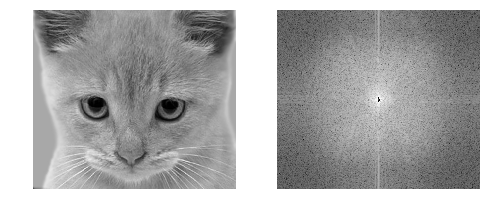

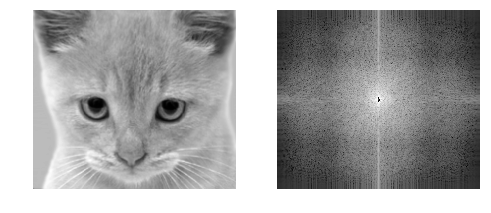

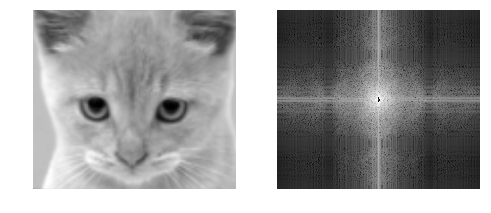

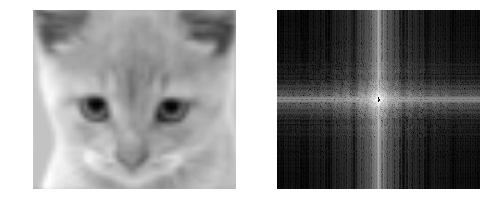

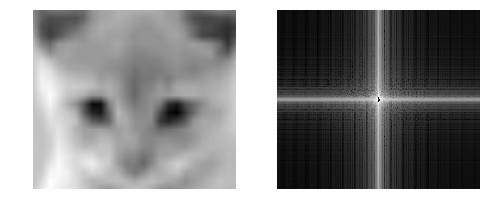

In [17]:
fname = 'cat'
ftype = 'bmp'
interpolation_type = 'BILINEAR'
img, _ = read_image('./hw2_data/task1and2_hybrid_pyramid/'+fname+'.'+ftype)
shape = img.shape

origin, origin_spec, img, img_spec = gaussian_pyramid(img)
plot_img(origin, float_to_int(origin_spec), 'gray')
cv_save('./task2/'+fname+'.jpg', origin)
cv_save('./task2/'+fname+'_pyramid_1.jpg', img)

expand, expand_spec = interpolation(img, shape, method=interpolation_type)
cv_save('./task2/'+fname+'_expand_'+interpolation_type+'_1.jpg', expand)
plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')

for i in range(2, 5):
    origin, origin_spec, img, img_spec = gaussian_pyramid(img)
#     plot_img(img, float_to_int(img_spec), 'gray')
    cv_save('./task2/'+fname+'_pyramid_'+str(i)+'.jpg', img)
    
    expand, expand_spec = interpolation(img, shape, method=interpolation_type)
    cv_save('./task2/'+fname+'_expand_'+interpolation_type+'_'+str(i)+'.jpg', expand)
    plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')
# laplacian_pyramid(origin, img)

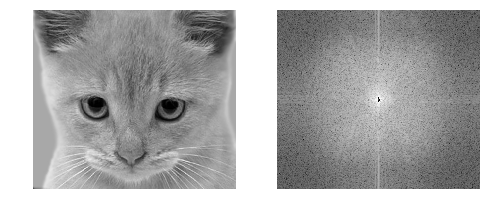

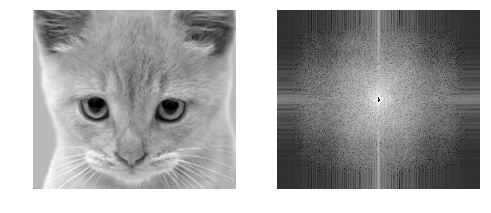

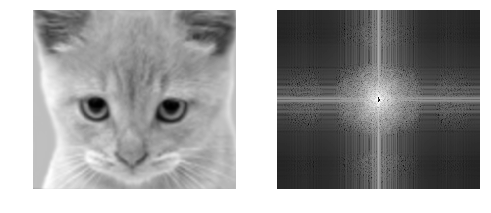

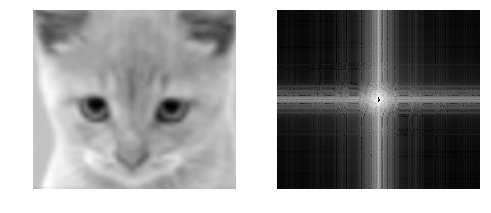

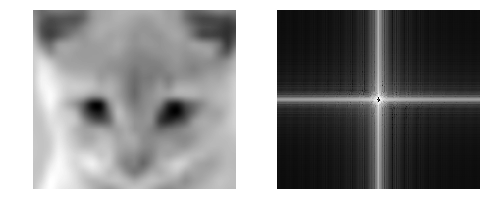

In [18]:
fname = 'cat'
ftype = 'bmp'
interpolation_type = 'BICUBIC'
img, _ = read_image('./hw2_data/task1and2_hybrid_pyramid/'+fname+'.'+ftype)
shape = img.shape

origin, origin_spec, img, img_spec = gaussian_pyramid(img)
plot_img(origin, float_to_int(origin_spec), 'gray')
cv_save('./task2/'+fname+'.jpg', origin)
cv_save('./task2/'+fname+'_pyramid_1.jpg', img)

expand, expand_spec = interpolation(img, shape, method=interpolation_type)
cv_save('./task2/'+fname+'_expand_'+interpolation_type+'_1.jpg', expand)
plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')

for i in range(2, 5):
    origin, origin_spec, img, img_spec = gaussian_pyramid(img)
#     plot_img(img, float_to_int(img_spec), 'gray')
    cv_save('./task2/'+fname+'_pyramid_'+str(i)+'.jpg', img)
    
    expand, expand_spec = interpolation(img, shape, method=interpolation_type)
    cv_save('./task2/'+fname+'_expand_'+interpolation_type+'_'+str(i)+'.jpg', expand)
    plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')
# laplacian_pyramid(origin, img)